In [9]:
from qdisk.model import Keplerian_velocity
from qdisk.classes import FitsImage
import eDiskplot as eplot
import analysis_utils as au
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
from qdisk.product import calculate_pvdiagram
from astropy.visualization import AsinhStretch
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
config = "SBLB"
line = "SO"
robust = 1.0
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["v_sys"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
r = 2
PA = 88.56
line = "12CO"
imagename = au.customimagepath + au.get_image_basename(source, config, line, robust=robust).replace(".image.fits", "_dv0.8.image.fits")

savefilename = au.VADPpath + au.get_image_basename(source, config, line, robust=robust).replace(".fits", "_pvDiagram_PA{}.fits".format(PA))
posax, velax, diag = calculate_pvdiagram(imagename=imagename, center_coord=center_coord, xlim=(-5, 5), ylim=(-5, 5), PA=PA, rrange=(-r, r), save=True, savefilename=savefilename, overwrite=True)

Loading data ...
Calculating PV diagram...
Done.
Saving PV diagram into ./VADP/L1489IRS_SBLB_12CO_robust_1.0.image_pvDiagram_PA88.56.fits...


In [2]:
from qdisk.classes import PVFitsImage
from qdisk.plot import PVDiagram

cube = FitsImage(
    au.customimagepath + au.get_image_basename(source, config, "SO", robust=robust)
)
cube.estimate_rms()


1.5769910243600433 1.5916032006370786 1.5623788480830079


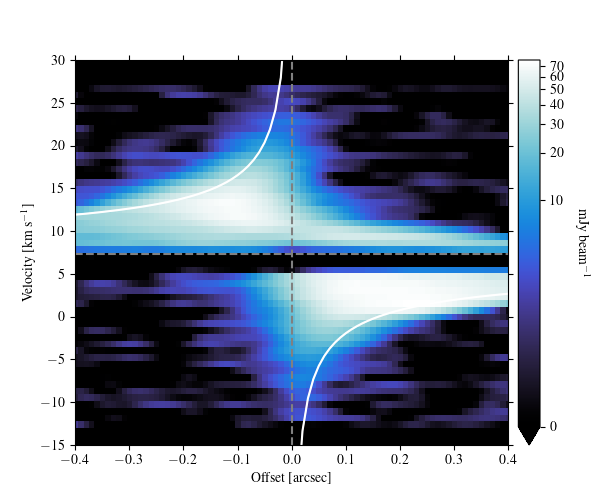

In [12]:
from qdisk.classes import PVFitsImage
from qdisk.plot import PVDiagram 

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=100)

# PA = 67.2
PA = 88.56
line = "12CO"

pvfitsname = au.VADPpath + au.get_image_basename(source, config, line, robust=robust).replace(".fits", "_pvDiagram_PA{}.fits".format(PA))
pvdiag = PVDiagram(pvfitsname, ax=ax, data_scaling_factor=1e3)
pvdiag.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0, stretch=AsinhStretch(a=0.01))
pvdiag.add_colorbar(label="mJy beam$^{-1}$", labelpad=20)
# pvdiag.overlay_contour(
#     "./VADP/L1489IRS_SBLB_SO_robust_1.0.image_pvDiagram_PA88.56.fits",
#     data_scaling_factor=1e3,
#     color="tab:orange",
#     levels=np.array([3, 5, 7, 10]) * cube.rms * 1e3,
# )

# ax.set_xlim(-0.5, 0.5)

ax.set_facecolor("black")

# Keplerian velocity
vsys = 7.3
Mstar = 1.403 / np.sin(np.radians(incl))**2
Mstar_u = 1.416 / np.sin(np.radians(incl))**2
Mstar_l = 1.390 / np.sin(np.radians(incl))**2
print(Mstar, Mstar_u, Mstar_l)
v_red = Keplerian_velocity(r=pvdiag.posax[pvdiag.posax < 0]*distance, Mstar=Mstar, incl=incl) + vsys
v_blue = - Keplerian_velocity(r=pvdiag.posax[pvdiag.posax > 0]*distance, Mstar=Mstar, incl=incl) + vsys
v_red_u = Keplerian_velocity(r=pvdiag.posax[pvdiag.posax < 0]*distance, Mstar=Mstar_u, incl=incl) + vsys
v_blue_u = - Keplerian_velocity(r=pvdiag.posax[pvdiag.posax > 0]*distance, Mstar=Mstar_u, incl=incl) + vsys 
v_red_l = Keplerian_velocity(r=pvdiag.posax[pvdiag.posax < 0]*distance, Mstar=Mstar_l, incl=incl) + vsys
v_blue_l = - Keplerian_velocity(r=pvdiag.posax[pvdiag.posax > 0]*distance, Mstar=Mstar_l, incl=incl) + vsys

ax.plot(pvdiag.posax[pvdiag.posax < 0], v_red, color="white")
ax.plot(pvdiag.posax[pvdiag.posax > 0], v_blue, color="white")
ax.fill_between(pvdiag.posax[pvdiag.posax > 0], v_blue_l, v_blue_u, color="white", alpha=0.25)
ax.fill_between(pvdiag.posax[pvdiag.posax < 0], v_red_l, v_red_u, color="white", alpha=0.25)

ax.set_ylim(-15, 30)
ax.set_xlim(-0.4, 0.4)

ax.set(xlabel="Offset [arcsec]", ylabel="Velocity [km s$^{-1}$]")

ax.axvline(x=0.0, color="grey", ls="dashed")
ax.axhline(y=vsys, color="grey", ls="dashed")



In [14]:
fig.savefig(au.figurepath + "C18O_SO_pvDiagram_comparison_zoomed.pdf", bbox_inches="tight", pad_inches=0.01)